In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

%matplotlib inline

In [21]:
HEAD_PATH = '/kaggle/input/coughing-frames/'

In [22]:
df = pd.read_csv(HEAD_PATH + 'frames_label.csv')
df = df.fillna(0)
df.head()

,file,label
0,./frames/S001_v001/S001_v001_frame_1.jpg,0.0
1,./frames/S001_v001/S001_v001_frame_2.jpg,0.0
2,./frames/S001_v001/S001_v001_frame_3.jpg,0.0
3,./frames/S001_v001/S001_v001_frame_4.jpg,0.0
4,./frames/S001_v001/S001_v001_frame_5.jpg,0.0


In [23]:
SPLIT_INDEX = 13768 # set to video 18-20

train_df = df.iloc[0:SPLIT_INDEX]
test_df = df.iloc[SPLIT_INDEX:]

In [24]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'test_df')

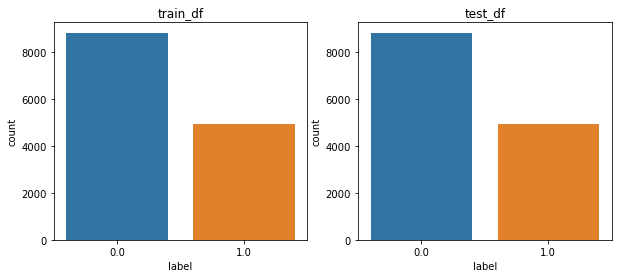

In [25]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.countplot(train_df['label'])
plt.title('train_df')

plt.subplot(1,2,2)
sns.countplot(train_df['label'])
plt.title('test_df')

In [26]:
from keras.preprocessing import image

def create_balance_df(train_df):
    not_cough_indices = train_df[train_df['label'] == 0].index
    random_indices = np.random.choice(not_cough_indices, train_df[train_df['label'] == 1]['label'].count(), replace=False)
    not_cough_sample = train_df.loc[random_indices]

    train_df = train_df[train_df['label'] == 1].append(not_cough_sample)
    return train_df

def get_image_array(file_list, image_size=224):
    image_list = []

    for file in file_list:
        file = HEAD_PATH + 'frames/' + file[2:]
        im = image.load_img(file, target_size=(image_size, image_size, 3))
        im = image.img_to_array(im)
        im = im/255
        image_list.append(im)
        
    image_list = np.array(image_list)
    return image_list

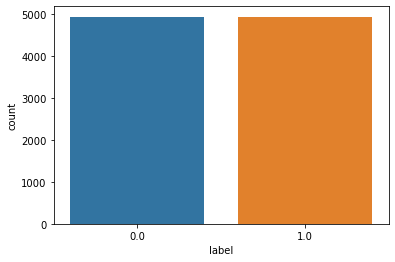

In [27]:
train_df = create_balance_df(train_df)
train_df = train_df.sample(frac=1).reset_index(drop=True)
sns.countplot(train_df['label'])

In [28]:
train_X, train_y = train_df['file'], train_df['label']
test_X, test_y = test_df['file'], test_df['label']

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(9886,) (9886,) (2136,) (2136,)


In [ ]:
train_X = get_image_array(train_X, image_size=64)
test_X = get_image_array(test_X, image_size=64)
train_X.shape

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

#defining the model architecture
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
from keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# compiling the model
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(train_X, train_y, epochs=50, validation_split=0.2, callbacks=[mcp_save], batch_size=64)

In [ ]:
epochs = [i for i in range(len(model.history.history['val_loss']))]
fig , ax = plt.subplots(1,2)
train_acc = model.history.history['accuracy']
train_loss = model.history.history['loss']
val_acc = model.history.history['val_accuracy']
val_loss = model.history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'g-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
print("Loss of the model is - " , model.evaluate(test_X,test_y)[0])
print("Accuracy of the model is - " , model.evaluate(test_X,test_y)[1]*100 , "%")